In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pyscipopt
import pickle
from pyscipopt import Model
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from enviornment import Enviornment
from data_loader import load_generated, MIPLib2010Loader, MIPLib2017Loader, load_test
from reward import Reward
from utils import *

In [2]:
def get_instances(actions = [-1,1,2,5,10,20,30], 
                  seeds = [0,1,2,3,4], 
                  time_limit=60, 
                  priority_or_freq = 'freq', 
                  heuristics_to_run = ['veclendiving']):
    '''
        Gets the set of all instances.  Note that it filters instances which find a 
        primal solution within specified time limit.  
        Params:
            actions - a list of all the actions that the store data is with respect to.
            seeds - a list of all the seeds that the stored data is with respect to.
            time_limit - time limit for instances (used to filter out instances with no solutions.
            priority_or_freq - a string of 'priority' or 'freq' indicating the action space.
            heuristics_to_run - a list of the heuristics to run
        Returns:
            a dictionary with key value tuple as (instance, state)
    '''
    
    # load instances
    max_rows = 100000
    max_cols = 100000

    data_loader_2010 = MIPLib2010Loader(max_rows = max_rows, max_cols = max_cols)
    instances_2010 = data_loader_2010.get_instances()
    data_loader_2017 = MIPLib2017Loader(max_rows = max_rows, max_cols = max_cols)
    instances_2017 = data_loader_2017.get_instances()
    instance_names_2010 = list(map(lambda x: x[0], instances_2010))
    instance_names_2017 = list(map(lambda x: x[0], instances_2017))
    unique_2010_instances = list(map(lambda x: x.replace('miplib_2010', 'miplib_2017'), instance_names_2010))
    unique_2010_instances = list(filter(lambda x: x not in instance_names_2017, unique_2010_instances) )
    unique_2010_instances = list(map(lambda x: x.replace('miplib_2017', 'miplib_2010'), unique_2010_instances))
    instances_2010_filtered = list(filter(lambda x: x[0] in unique_2010_instances, instances_2010))
    instances = instances_2017 + instances_2010_filtered

    # dict to store instances which find bound within time limit
    under_time_limit_dict = {}
    
    # iterate through instances
    for instance, _ in instances:
        
        for action in actions:

            action_input = {'veclendiving': action}
            
            for seed in seeds:
                
                reward_path = get_rewards_write_path(instance, priority_or_freq, action_input, seed)
                try: 
                    

                    with open(reward_path, 'rb') as p:
                        reward = pickle.load(p)

                    if reward['primal_integral'] < time_limit - 0.001:
                        if not instance in under_time_limit_dict:
                            under_time_limit_dict[instance] = reward['state']        
                            
                except:
                    if instance in under_time_limit_dict:
                        del under_time_limit_dict[instance]
                    print(reward_path)
                    print('  ', instance, action, seed)
                        
    return under_time_limit_dict

In [3]:
class LinUCB(object):
    
    
    def __init__(self, actions, state_dim, alpha = 0.1):
        '''
            actions - a list of the actions as strings.
            state_dim - the state dimension of the problem.
            alpha_dim - coefficient for UCB.
        '''
        
        self.actions = actions
        self.state_dim = state_dim
        self.alpha = alpha 
        
        self.theta_a = {}
        self.A_a = {}
        self.b_a = {}
        
        # initialize linear weights
        for action in self.actions:    
            
            self.theta_a[action] = np.zeros(self.state_dim)
            self.A_a[action] = np.eye(self.state_dim)
            self.b_a[action] = np.zeros(self.state_dim)
            
        self.t = 0
        
        
    def get_action(self, state): 
        '''
            Greedily gets an action based on store parameters and UCB.
            Params:
                state - a numpy array of the state
            Returns:
                the action assosiated with the highest expected return.
        '''
        
        action_scores = np.zeros(len(self.actions))
        
        for i  in range(len(self.actions)):
            
            action = self.actions[i]
            
            A_a_inv = np.linalg.inv(self.A_a[action])
            b_a = self.b_a[action]
            theta_hat_a = np.dot(A_a_inv, b_a)
            p_a = np.dot(theta_hat_a, state) + self.alpha*np.sqrt(np.dot(state.T, np.dot(A_a_inv, state)))
            
            action_scores[i] = p_a
                
        # break ties arbitrarily
        best_action_index = np.random.choice(np.flatnonzero(action_scores == action_scores.max()))
        best_action = self.actions[best_action_index]
        
        return best_action
    
    
        
    def get_best_action(self, state): 
        '''
            Greedily gets an action based on store parameters.  Does not use UCB.
            Params:
                state - a numpy array of the state
            Returns:
                the action assosiated with the highest expected return.
        '''
        
        action_scores = np.zeros(len(self.actions))
        
        for i  in range(len(self.actions)):
            
            action = self.actions[i]
            
            A_a_inv = np.linalg.inv(self.A_a[action])
            b_a = self.b_a[action]
            theta_hat_a = np.dot(A_a_inv, b_a)
            p_a = np.dot(theta_hat_a, state) 
            
            action_scores[i] = p_a
            
        # break ties arbitrarily
        best_action_index = np.random.choice(np.flatnonzero(action_scores == action_scores.max()))
        best_action = self.actions[best_action_index]
        
                
        return best_action
    
    
    def update_params(self, reward, state, action):
        '''
            Updates parameters given a reward, state, and action
        '''
        
        self.A_a[action] = self.A_a[action] + np.outer(state, state)
        self.b_a[action] = self.b_a[action] + reward*state
        
        return

In [4]:
def get_train_test_split(instances, tr_te_split_ratio=0.8):
    '''
        Gets a train, test split from the data randomly.
        Params:
            instances - a dictionary of the instances (instance:state) pairs.
            tr_te_split_ratio - the train/test ratio of the data.  
        Returns:
            two dictionaries split randomly as train and test data. 
    '''
    
    # get train/test indicies
    perm = np.random.permutation(len(instances))
    train_idx = perm[:int(tr_te_split_ratio*(len(instances)))]
    test_idx = perm[int(tr_te_split_ratio*(len(instances))):]

    # fill train/test sets
    count = 0
    train_instances = {}
    test_instances = {}
    
    for instance, state in instances.items():
        if count in train_idx:
            train_instances[instance] = state
        else:
            test_instances[instance] = state
        count += 1
        
    return train_instances, test_instances

In [5]:
def get_random_instance(instances):
    '''
        Chooses a random instance from the set of train and test instances.  
        Params:
            instances - a dict of the instances.
        Returns:
            a tuple of the instance name and the state as a numpy array. 
    '''
    
    # select a random instances
    rand_instance = np.random.randint(len(instances))
    
    instance = list(instances.keys())[rand_instance]
    state = instances[instance]
    
    state_as_arr = np.array(list(state.values()))
    
    return instance, state_as_arr

In [6]:
def take_action_on_instance(instance, action, seed=None, priority_or_freq = 'freq', heuristic = 'veclendiving'):
    '''
        Takes action on instance.
        Params:
            instance - a dict of the instances.
            action - the action to take
            seed - a seed for choosing the instance, if not specified then choose one at random.
        Returns:
            the negative primal integral
    '''
    
    # choose seed if not specified
    if seed is None:
        seed = np.random.randint(5)
        
    # cast acton tp doct
    action_dict = {
        heuristic : action
    }
    
    # get reward assosiated with action/instance/seed
    reward_path = get_rewards_write_path(instance, priority_or_freq, action_dict, seed)
    with open(reward_path, 'rb') as p:
        reward = pickle.load(p)

    return - reward['primal_integral']

In [7]:
def eval_on_all(bandit, instances, seeds = [0,1,2,3,4]):
    '''
        Greedily evaluates the bandit on all specified instances.  The evaluation is run across
        all seeds.
        Params:
            bandit - a trained bandit
            instances - a dict of the instances
        Returns:
            a tuple of the average reward, and the actions
    '''
    
    total_reward = 0
    actions = []
    
    for instance, state in instances.items():
        
        ep_reward = 0
        for seed in seeds:
            state_as_arr = np.array(list(state.values()))

            action = bandit.get_action(state_as_arr)
            reward = take_action_on_instance(instance, action, seed)

            ep_reward += reward
        avg_ep_reward = ep_reward / len(seeds)
        
        total_reward += avg_ep_reward
        
    avg_reward = total_reward / len(instances)
    
    return avg_reward, actions

In [8]:
def compute_optimal_action_reward(instances, actions, seeds=[0,1,2,3,4]):
    '''
        Computes the optimal reward for each instance by checking all actions.  
        Params:
            instances - 
            actions - 
            seeds - 
        Returns:
            the optimal reward given the action
    '''

    opt_instance_rewards = []
    
    for instance in instances.keys():
        
        opt_action = -1
        opt_action_reward = -1e7
        
        for action in actions:
            
            # compute reward across all instances
            instance_action_reward = 0
            for seed in seeds:
                reward = take_action_on_instance(instance, action, seed)
                instance_action_reward += reward
            instance_action_reward = instance_action_reward / len(seeds)
            
            if instance_action_reward > opt_action_reward:
                opt_action_reward = instance_action_reward
                opt_action = action
                
        opt_instance_rewards.append(opt_action_reward)
        
    opt_val = np.mean(opt_instance_rewards)
    return opt_val

In [9]:
def compute_scip_action_reward(instances, seeds=[0,1,2,3,4]):
    '''
        Computes the optimal reward for each instance by checking all actions.  
        Params:
            instances - 
            seeds - 
        Returns:
            the optimal reward given the action
    '''

    scip_rewards = []
    
    scip_action = 10
    
    
    for instance in instances.keys():
            
        # compute reward across all instances
        scip_reward = 0
        for seed in seeds:
            reward = take_action_on_instance(instance, scip_action, seed)
            scip_reward += reward
        scip_reward = scip_reward / len(seeds)
            
        scip_rewards.append(scip_reward)
        
    scip_avg_reward = np.mean(scip_rewards)
    
    return scip_avg_reward

In [10]:
def get_scaler_normalize_train_states(train_instances):
    '''
        Get a scaler for the input. 
        Params:
            train_instances - a dict of the training instances. 
        Returns:
            returns a sklearn scaler.   
    '''
    train_states = list(train_instances.values())

    train_states = list(map(lambda x: (list(x.values())), train_states))
    train_states = np.array(train_states)
    
    scaler = MinMaxScaler()
    scaler.fit(train_states)
    
    return scaler

## Test

In [11]:
np.random.seed(0)

In [12]:
actions = [-1, 1, 10]
#actions = [-1, 1, 2, 5, 10, 20, 30]

time_limit = 60*5
state_dim = 5

In [13]:
instances = get_instances(actions=actions, time_limit=time_limit)
train_instances, test_instances = get_train_test_split(instances)

print(len(train_instances))
print(len(test_instances))

NameError: name 'get_rewards_write_path' is not defined

In [27]:
scaler = get_scaler_normalize_train_states(train_instances)

In [28]:
episodes = 1000

seed = 1234
n_runs = 1

In [35]:
alpha = 0.75
bandit = LinUCB(actions, state_dim, alpha)

In [36]:
train_rewards = []
train_actions = []

test_rewards = []
test_actions = []

for run in range(n_runs):
    
    print('Run:', run+1)
    np.random.seed(seed + run)
    
    train_rewards_ep = []
    train_actions_ep = []

    test_rewards_ep = []
    test_actions_ep = []

    for episode in range(episodes):
        
        if (episode + 1) % 100 == 0:
            print('  episode:', episode + 1)

        instance, state = get_random_instance(train_instances)

        state = scaler.transform(state.reshape(1,state_dim)).reshape(state_dim,)
        action = bandit.get_action(state)

        reward = take_action_on_instance(instance, action)

        bandit.update_params(reward, state, action)

        train_reward, _ = eval_on_all(bandit, train_instances)
        test_reward, _ = eval_on_all(bandit, test_instances)

        train_rewards_ep.append(train_reward)
        #train_actions.append(train_action)
        test_rewards_ep.append(test_reward)
        #test_actions.append(test_action)
        
    train_rewards.append(train_rewards_ep)
    test_rewards.append(test_rewards_ep)

Run: 1
  episode: 100
  episode: 200
  episode: 300
  episode: 400
  episode: 500
  episode: 600
  episode: 700
  episode: 800
  episode: 900
  episode: 1000
Run: 2
  episode: 100
  episode: 200
  episode: 300
  episode: 400
  episode: 500
  episode: 600
  episode: 700
  episode: 800
  episode: 900
  episode: 1000
Run: 3
  episode: 100
  episode: 200
  episode: 300
  episode: 400
  episode: 500
  episode: 600
  episode: 700
  episode: 800
  episode: 900
  episode: 1000
Run: 4
  episode: 100
  episode: 200
  episode: 300
  episode: 400
  episode: 500
  episode: 600
  episode: 700
  episode: 800
  episode: 900
  episode: 1000
Run: 5
  episode: 100
  episode: 200
  episode: 300
  episode: 400
  episode: 500
  episode: 600
  episode: 700
  episode: 800
  episode: 900
  episode: 1000


In [41]:
train_rewards_mean = np.mean(train_rewards, axis=0)
test_rewards_mean = np.mean(test_rewards, axis=0)

In [42]:
# get optimal rewards for train and test
train_opt = compute_optimal_action_reward(train_instances, actions)
test_opt = compute_optimal_action_reward(test_instances, actions)

# get scip default rewards for train and test
train_scip_reward = compute_scip_action_reward(train_instances)
test_scip_reward = compute_scip_action_reward(test_instances)

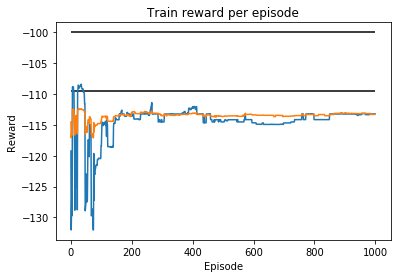

In [43]:
plt.plot(train_rewards[0])
plt.plot(train_rewards_mean)
#plt.plot(train_rewards_mean)
plt.hlines(train_scip_reward, 0, episodes)
plt.hlines(train_opt, 0, episodes)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Train reward per episode')

plt.show()

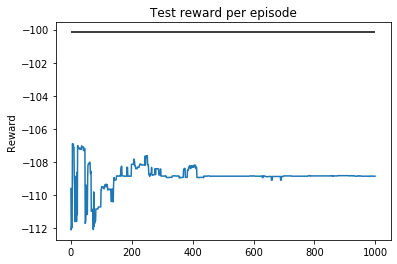

In [44]:
plt.plot(test_rewards_mean)
plt.hlines(test_scip_reward, 0, episodes)
#plt.hlines(test_opt, 0, episodes)

plt.ylabel('Reward')
plt.title('Test reward per episode')

plt.show()

In [78]:
# load instances
max_rows = 100000
max_cols = 100000

data_loader_2010 = MIPLib2010Loader(max_rows = max_rows, max_cols = max_cols)
instances_2010 = data_loader_2010.get_instances()

data_loader_2017 = MIPLib2017Loader(max_rows = max_rows, max_cols = max_cols)
instances_2017 = data_loader_2017.get_instances()


instance_names_2010 = list(map(lambda x: x[0], instances_2010))
instance_names_2017 = list(map(lambda x: x[0], instances_2017))

unique_2010_instances = list(map(lambda x: x.replace('miplib_2010', 'miplib_2017'), instance_names_2010))
unique_2010_instances = list(filter(lambda x: x not in instance_names_2017, unique_2010_instances) )
unique_2010_instances = list(map(lambda x: x.replace('miplib_2017', 'miplib_2010'), unique_2010_instances))

instances_2010_filtered = list(filter(lambda x: x[0] in unique_2010_instances, instances_2010))

instances = instances_2017 + instances_2010_filtered

In [79]:
print(len(instances_2010_filtered))

79


In [80]:
total_instances = 0
total_instances += len(instances_2010_filtered)
total_instances += len(instances_2017)

print('2010 instances:', len(instances_2010_filtered))
print('2017 instances:', len(instances_2017))
print('Total instances:', total_instances)

2010 instances: 79
2017 instances: 376
Total instances: 455


In [81]:

print(len(instances))

455


In [82]:
for instance in instances:
    print(instance)
    name = instance[0]
    
    model = Model()
    model.readProblem(name)

('data/miplib_2017/collection/30_70_45_05_100.mps', 9.0)
('data/miplib_2017/collection/30_70_45_095_100.mps', 3.0)
('data/miplib_2017/collection/30_70_45_095_98.mps', 12.0)
('data/miplib_2017/collection/30n20b8.mps', 302.0)
('data/miplib_2017/collection/50v-10.mps', 3311.179984)
('data/miplib_2017/collection/a1c1s1.mps', 11503.44413)
('data/miplib_2017/collection/a2c1s1.mps', 10889.13763)
('data/miplib_2017/collection/academictimetablesmall.mps', 0.0)
('data/miplib_2017/collection/acc-tight2.mps', 0.0)
('data/miplib_2017/collection/acc-tight4.mps', 0.0)
('data/miplib_2017/collection/acc-tight5.mps', 0.0)
('data/miplib_2017/collection/aflow30a.mps', 1158.0)
('data/miplib_2017/collection/aflow40b.mps', 1168.0)
('data/miplib_2017/collection/air04.mps', 56137.0)
('data/miplib_2017/collection/air05.mps', 26374.0)
('data/miplib_2017/collection/aligninq.mps', 2713.0)
('data/miplib_2017/collection/app1-1.mps', -3.0)
('data/miplib_2017/collection/app1-2.mps', -41.0)
('data/miplib_2017/collectio

KeyboardInterrupt: 

In [83]:
len(instances)

455

In [93]:
num_actions = 3
num_seeds = 5
time_mins = 3

n_procs = 6

In [94]:
total_mins = num_actions * num_seeds * total_instances * time_mins
total_hours = total_mins / 60

In [95]:
total_hours / n_procs

56.875

In [1]:
def get_stats(result_1, result_10, result_m1, reward_1, reward_10, reward_m1, seed, heur):
    
    r_1 = result_1.replace('seedx', 'seed' + str(seed))
    r_10 = result_10.replace('seedx', 'seed' + str(seed))
    r_m1 = result_m1.replace('seedx', 'seed' + str(seed))
    
    with open(r_1, 'r') as f:
        lines_1 = f.readlines()

    with open(r_10, 'r') as f:
        lines_10 = f.readlines()

    with open(r_m1, 'r') as f:
        lines_m1 = f.readlines()

    rp_1 = reward_1.replace('seedx', 'seed' + str(seed))
    rp_10 = reward_10.replace('seedx', 'seed' + str(seed))
    rp_m1 = reward_m1.replace('seedx', 'seed' + str(seed))
        
    with open(rp_1, 'rb') as p:
        pi_1 = pickle.load(p)['primal_integral']
        
    with open(rp_10, 'rb') as p:
        pi_10 = pickle.load(p)['primal_integral']
        
    with open(rp_m1, 'rb') as p:
        pi_m1 = pickle.load(p)['primal_integral']
        
        
    line_1_vl = list(filter(lambda x: heur in x, lines_1))
    line_10_vl = list(filter(lambda x: heur in x, lines_10))
    line_m1_vl = list(filter(lambda x: heur in x, lines_m1))

    cols = ['seed', heur + '_freq', 'PrimalIntegral', 'ExecTime', 'SetupTime', 'Calls', 'Found', 'Best']

    d = []

    e_1 = line_1_vl[0].split(" ")
    e_1 = list(filter(lambda x: x != '' and x != ':' and x != heur, e_1))
    e_1 = [seed, '1', pi_1] + e_1 
    e_1[-1] = e_1[-1].replace('\n', '')
    e_1 = list(map(lambda x: float(x), e_1))

    e_10 = line_10_vl[0].split(" ")
    e_10 = list(filter(lambda x: x != '' and x != ':' and x != heur, e_10))
    e_10 = [seed, '10', pi_10] + e_10
    e_10[-1] = e_10[-1].replace('\n', '')
    e_10 = list(map(lambda x: float(x), e_10))

    e_m1 = line_m1_vl[0].split(" ")
    e_m1 = list(filter(lambda x: x != '' and x != ':' and x != heur, e_m1))
    e_m1 = [seed, '-1', pi_m1] + e_m1
    e_m1[-1] = e_m1[-1].replace('\n', '')
    e_m1 = list(map(lambda x: float(x), e_m1))

    d = [e_1, e_10, e_m1]

    df = pd.DataFrame(d, columns=cols)
    '''
    cols = ['veclendiving_freq', 'Calls', 'Nodes', 'LP Iters', 'Backtracks', 'Conflicts', 'MinDepth', 'MaxDepth', 
     'AvgDepth', 'RoundSols', 'NLeafSols', 'MinSolDpt', 'MaxSolDpt', 'AvgSolDpt']

    d = []

    e_1 = line_1_vl[1].split(" ")
    e_1 = list(filter(lambda x: x != '' and x != ':' and x != 'veclendiving', e_1))
    e_1 = ['1'] + e_1
    e_1[-1] = e_1[-1].replace('\n', '')

    e_10 = line_10_vl[1].split(" ")
    e_10 = list(filter(lambda x: x != '' and x != ':' and x != 'veclendiving', e_10))
    e_10 = ['10'] + e_10
    e_10[-1] = e_10[-1].replace('\n', '')

    e_m1 = line_m1_vl[1].split(" ")
    e_m1 = list(filter(lambda x: x != '' and x != ':' and x != 'veclendiving', e_m1))
    e_m1 = ['-1'] + e_m1
    e_m1[-1] = e_m1[-1].replace('\n', '')

    d = [e_1, e_10, e_m1]

    df_2 = pd.DataFrame(d, columns=cols)
    '''
    df_2 = None

    return df, df_2

In [2]:
#results

In [3]:
seeds = [0,1,2,3,4]
#seeds = [0,1]
heur = 'veclendiving'
results = os.listdir('results/')

results = list(filter(lambda x: heur + '_10.txt' in x, results))
results = list(map(lambda x: 'results/' + x, results))
results = list(filter(lambda x: 'seed' + str(len(seeds)-1) in x, results))
results = list(map(lambda x: x.replace('seed' + str(len(seeds)-1), 'seedx'), results))

In [4]:
print(len(results))

450


In [487]:
for idx in range(len(results)):
    
    # get results/results for index
    result_10 = results[idx]
    result_1 = result_10.replace(heur + '_10', heur + '_1')
    result_m1 = result_1.replace(heur + '_1', heur + '_-1')

    reward_10 = result_10.replace('results/', 'rewards/').replace('txt', 'pickle')
    reward_1 = reward_10.replace(heur + '_10', heur + '_1')
    reward_m1 = reward_1.replace(heur + '_1', heur + '_-1')


    print('Instance: ', result_1)

    # get dataframes for each seed and concat
    dfs = []
    for seed in seeds:
        df, _ = get_stats(result_1, result_10, result_m1, reward_1, reward_10, reward_m1, seed, heur)
        dfs.append(df)

    stats = pd.concat(dfs).sort_values([heur + '_freq', 'seed'])
    
    
    for val in [1, 10, -1]:
    
        avg = stats[np.abs(stats[heur + '_freq'] - val) <= 1e-2].mean()

        print('  freq:', val)
        print('    PrimalIntegral  :', avg['PrimalIntegral'])
        print('    ExecTime        :', avg['ExecTime'])
        print('    Calls           :', avg['Calls'])
        print('    Found           :', avg['Found'])

Instance:  results/30n20b8_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 157.32050796408052
    ExecTime        : 1.0
    Calls           : 16.0
    Found           : 3.5
  freq: 10
    PrimalIntegral  : 250.48067757934587
    ExecTime        : 0.0
    Calls           : 3.0
    Found           : 1.0
  freq: -1
    PrimalIntegral  : 153.0889452973519
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/30_70_45_05_100_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/30_70_45_095_100_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls

  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/beasleyC2_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 27.970536120945596
    ExecTime        : 2.0
    Calls           : 59.0
    Found           : 10.0
  freq: 10
    PrimalIntegral  : 26.199154149710854
    ExecTime        : 3.5
    Calls           : 43.0
    Found           : 14.5
  freq: -1
    PrimalIntegral  : 21.45074273828547
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/beasleyC3_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 82.8309406108857
    ExecTime        : 10.0
    Calls           : 75.0
    Found           : 0.5
  freq: 10


  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/eilC76-2_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 77.09334839735737
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 67.6312964460958
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 90.77064691797493
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/enlight_hard_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 1.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  

  freq: 1
    PrimalIntegral  : 67.34229382850299
    ExecTime        : 14.5
    Calls           : 55.0
    Found           : 1.0
  freq: 10
    PrimalIntegral  : 69.58680286665006
    ExecTime        : 15.0
    Calls           : 52.5
    Found           : 1.5
  freq: -1
    PrimalIntegral  : 52.755405096657285
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/mc7_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 108.84130442556582
    ExecTime        : 11.5
    Calls           : 26.5
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 108.64909254968916
    ExecTime        : 9.5
    Calls           : 25.5
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 97.01277877388145
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/mc8_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 52.45904065957548
    ExecTime        : 17.0
    Calls           : 61.0
    Foun

  freq: 10
    PrimalIntegral  : 5.176144244105405
    ExecTime        : 17.5
    Calls           : 811.5
    Found           : 2.5
  freq: -1
    PrimalIntegral  : 5.6029126213592235
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/neos-1605075_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/neos-1616732_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 6.413320988747927
    ExecTime        : 2.5
    Calls           : 282.5
    Found           : 0.5
  freq: 10
    PrimalIntegral  : 7.2479239910809365
    ExecTime        : 5.0
    Calls           : 472.0
    Found           : 1.0
  

  freq: 10
    PrimalIntegral  : 193.5527391807447
    ExecTime        : 6.5
    Calls           : 107.5
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 179.7661867735947
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/neos-3759587-noosa_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 27.500000003382695
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 24.000000003426145
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 30.50000000334545
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/neos-4333464-siret_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 86.77188057058127
    ExecTime        : 21.5
    Calls           : 58.0
    Found           : 1.0
  freq: 10
    PrimalIntegral  : 66.07291526829894
    ExecTime        : 29.5
    Call

  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 136.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 91.00000000000001
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/neos-827175_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 71.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 186.5
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 59.5
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/neos-831188_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime 

    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/pg_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 109.4194411659293
    ExecTime        : 35.0
    Calls           : 35.5
    Found           : 1.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 13.5
    Calls           : 13.5
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/physiciansched5-3_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 299.99999999999994
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 299.99999999999994
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 299.99999999999994
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/pigeon-08_freq_seedx_veclendi

  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/square47_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: 10
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
  freq: -1
    PrimalIntegral  : 300.0
    ExecTime        : 0.0
    Calls           : 0.0
    Found           : 0.0
Instance:  results/supportcase17_freq_seedx_veclendiving_1.txt
  freq: 1
    PrimalIntegral  : 36.504126928479806
    ExecTime        : 2.5
    Calls           : 96.0
    Found           : 3.0
  freq: 10
    PrimalIntegral  : 34.4110479664532

In [407]:
for val in [1, 10, -1]:
    
    avg = stats[np.abs(stats['veclendiving_freq'] - val) <= 1e-2].mean()
    
    print('freq:', val)
    print('  PrimalIntegral  :', avg['PrimalIntegral'])
    print('  ExecTime        :', avg['ExecTime'])
    print('  Calls           :', avg['Calls'])
    print('  Found           :', avg['Found'])

freq: 1
  PrimalIntegral  : 108.74032764711185
  ExecTime        : 47.6
  Calls           : 158.8
  Found           : 13.8
freq: 10
  PrimalIntegral  : 79.00524371602965
  ExecTime        : 24.0
  Calls           : 303.4
  Found           : 13.6
freq: -1
  PrimalIntegral  : 262.58682222399943
  ExecTime        : 0.0
  Calls           : 0.0
  Found           : 0.0


In [ ]:
data/miplib_2017/collection/sp98ar.mps
data/miplib_2017/collection/square23.mps

